# Context

Click-through rate (CTR) is a critical metric in digital marketing, representing the effectiveness of online advertisements in driving user engagement. Optimising CTR helps reduce customer acquisition costs and improve campaign ROI. Unlike traditional marketing methods, online campaigns are data-driven and scalable, allowing for advanced targeting strategies. [This dataset](https://www.kaggle.com/datasets/swekerr/click-through-rate-prediction) contains data related to click/no-click recorded for different users. ***In this analysis, I will be answering the following questions:***

---

#### EDA-Based Questions (Exploratory Data Analysis

2. #### [How does user demographic information (age, income) relate to CTR?](#Q:-Do-time-based-behavior-(e.g.,-daily-time-spent-on-site,-internet-usage,-timestamp-patterns)-influence-likelihood-of-clicking-on-ads?)

3. #### [Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?](#Q:-Do-time-based-behavior-(e.g.,-daily-time-spent-on-site,-internet-usage,-timestamp-patterns)-influence-likelihood-of-clicking-on-ads?)  

4. #### [Are there geographic differences in ad engagement (by city or country)?](#Q:-Do-certain-types-of-'Ad-Topic-Line'-perform-better-in-terms-of-CTR?)  

5. #### [Do certain 'Ad Topic Line' perform better in terms of CTR?](#Q:-Do-certain-types-of-'Ad-Topic-Line'-perform-better-in-terms-of-CTR?)  

6. #### [What is the relationship between internet use and time on site, and how do those correlate with CTR?](#Q:-)  
---

### Post Model-Training/Counterfactual Questions**

6. Which user attributes (e.g., age, income, location, behavior) are most influential in driving ad clicks, according to the predictive model?

7. Which customer segments are the most unpredictable or inconsistent in terms of ad engagement, and where does the model struggle to make accurate predictions?

8. What specific changes, such as adjusting ad delivery timing or targeting different user profiles could improve engagement among the least responsive audiences?  

9. Which types of users are most responsive to changes in key factors like income level, site usage, or timing, and how can we leverage that for better targeting?  

10. What hidden trends or unexpected feature combinations did the model uncover that could inform more effective marketing strategies moving forward?  

---
### Click to see complete analysis process, answers, and reccomendations.
---


**NOTE**: This entire analysis is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.

Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

# Importing Important Libraries

In [1]:
# data wrangling
import calendar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# numerical analysis
import numpy as np
import scipy.stats as stats

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    log_loss, roc_curve)


# model explainability
import shap
from sklearn.inspection import PartialDependenceDisplay as pdp

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
#hide_input
## Reusable stuff.
print("Completely hidden... reusable code for future.")

def plot_ctr_by_numeric_columns(
        df,
        cols,
        *,
        n_rows: int = 2,
        n_cols: int = 4,
        n_bins: int = 8,
        rolling_window: int = 15,
        figsize: tuple = (30, 8),
        num_colors=None,
        bins_map: dict | None = None,
        smooth_map: dict | None = None,
    ):
    """
    Plots CTR by numeric columns with per-column overrides.

    Parameters
    ----------
    df : pd.DataFrame
        Input data. Must contain a binary column 'Clicked on Ad'.
    cols : list[str]
        Numeric columns to analyse.
    n_rows, n_cols : int
        Layout of the subplot grid (used *as-is*; make sure it can hold 2·len(cols) plots).
    n_bins : int
        Default number of equal-width bins for bar plots.
    rolling_window : int
        Default window size for the smoothed line.
    figsize : tuple[int, int]
        Overall figure size.
    num_colors : list[str] | None
        Optional colour list; defaults to seaborn tab10.
    bins_map : dict[str, int] | None
        Optional per-column bin overrides. Only listed columns are affected.
    smooth_map : dict[str, int] | None
        Optional per-column smoothing-window overrides. Only listed columns are affected.
    """
    if num_colors is None:
        num_colors = sns.color_palette("tab10", len(cols))

    # fall-back to empty dicts so we can always call .get()
    bins_map = bins_map or {}
    smooth_map = smooth_map or {}

    plt.figure(figsize=figsize)

    # ---- smoothed line plots -------------------------------------------------
    for i, col in enumerate(cols, start=1):
        ax = plt.subplot(n_rows, n_cols, i)
        df_tmp = df.copy()
        df_tmp[col] = df_tmp[col].round(1)

        grouped = (
            df_tmp
            .groupby(col)
            .agg(total_clicks=('Clicked on Ad', 'sum'),
                 total_ads=('Clicked on Ad', 'count'))
            .sort_index()
        )

        grouped['ctr'] = grouped['total_clicks'] / grouped['total_ads']
        win = smooth_map.get(col, rolling_window)        # per-column override
        grouped['ctr_smooth'] = (
            grouped['ctr']
            .rolling(window=win, center=True, min_periods=1)
            .mean()
        )

        sns.lineplot(
            ax=ax,
            x=grouped.index,
            y=grouped['ctr_smooth'],
            marker='o',
            color=num_colors[i - 1],
        )

        plt.title(f'CTR by {col} (smoothed, win={win})', fontsize = 20)
        plt.xlabel(col.title(), fontsize = 20)
        plt.ylabel('CTR', fontsize = 20)
        
        # ax.set(
        #     title=f'CTR by {col} (smoothed, win={win})',
        #     xlabel=col,
        #     ylabel='CTR'
        # )

    # ---- equal-width binned bar plots ---------------------------------------
    for i, col in enumerate(cols, start=len(cols) + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        bins = bins_map.get(col, n_bins)                 # per-column override
        bin_labels = [f'B{i}' for i in range(1, bins + 1)]
        df[f'{col}_bin'] = pd.cut(df[col], bins=bins, labels=bin_labels)

        grouped_bin = (
            df
            .groupby(f'{col}_bin')
            .agg(total_clicks=('Clicked on Ad', 'sum'),
                 total_ads=('Clicked on Ad', 'count'))
        )
        grouped_bin['ctr'] = grouped_bin['total_clicks'] / grouped_bin['total_ads']

        sns.barplot(
            ax=ax,
            x=grouped_bin.index,
            y=grouped_bin['ctr'],
            color=num_colors[i - len(cols) - 1],
        )

        plt.title(f'CTR by {col} (equal-width bins={bins})', fontsize = 20)
        plt.xlabel(f'{col.title()} Bin', fontsize = 20)
        plt.ylabel('CTR', fontsize = 20)
        
        # ax.set(
        #     title=f'CTR by {col} (equal-width bins={bins})',
        #     xlabel=col,
        #     ylabel='CTR'
        # )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

Completely hidden... reusable code for future.


In [3]:
df = pd.read_csv('/kaggle/input/click-through-rate-prediction/ad_10000records.csv')

# Some EDA.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,10000.0,61.660757,15.704142,32.60,48.8600,59.59,76.58,90.97
Age,10000.0,35.940100,8.572973,19.00,29.0000,35.00,42.00,60.00
Area Income,10000.0,53840.047721,13343.708718,13996.50,44052.3025,56180.93,61840.26,79332.33
Daily Internet Usage,10000.0,177.759831,40.820951,105.22,140.1500,178.92,212.67,269.96
Clicked on Ad,10000.0,0.491700,0.499956,0.00,0.0000,0.00,1.00,1.00


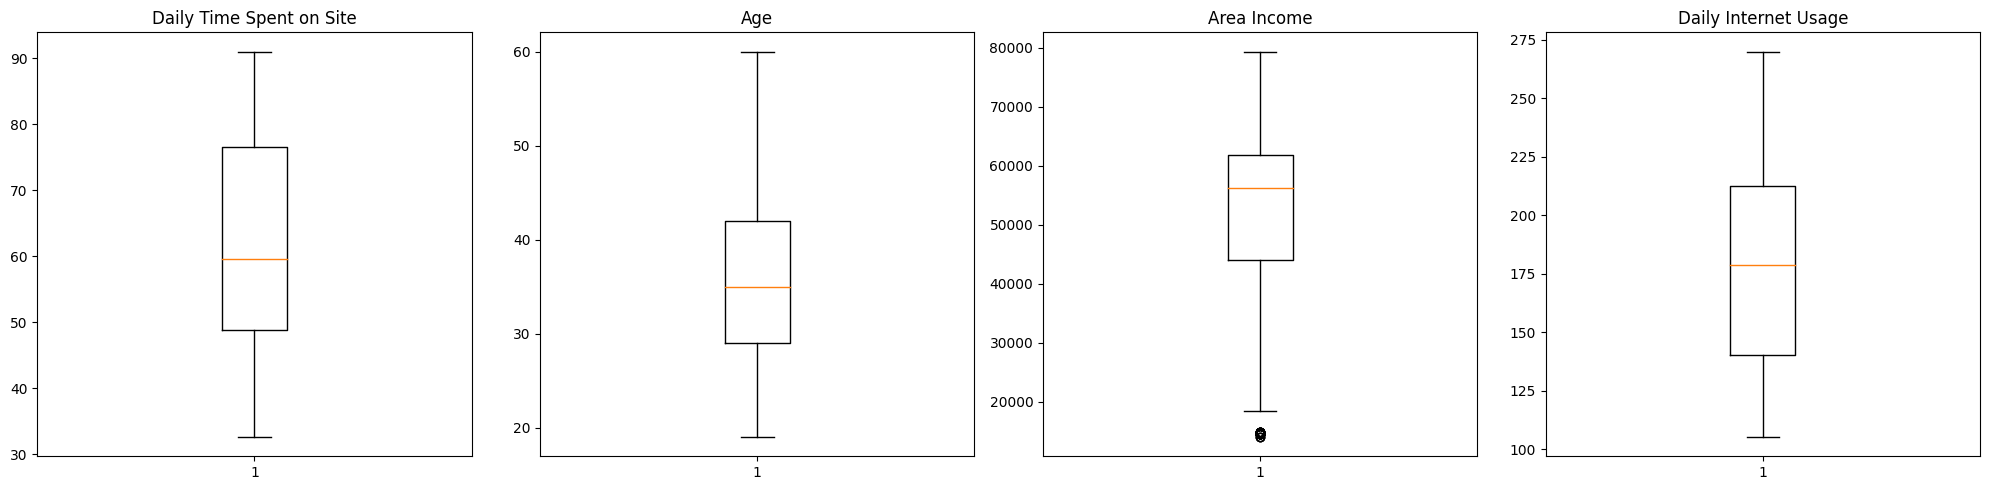

In [6]:
numerical_cols = df.select_dtypes(include = 'number').columns[:-1]

fig, axes = plt.subplots(1, len(numerical_cols), figsize = (20, 5))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

**Observation**   

The dataset is quite nice and clean... Only a few potential outliers observed under the area income. I will leave them in for now however, if they skew model predictions, I will take them out.

In [7]:
# extracting time-based temporal features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday
df['month'] = df['Timestamp'].dt.month


# category encodings
label_encoders = {}
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.title().str.strip()

    le = LabelEncoder()
    df[col + '_label'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,hour,day,weekday,month,Ad Topic Line_label,City_label,Gender_label,Country_label
0,62.26,32.0,69481.85,172.83,Decentralized Real-Time Circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,21,9,3,6,96,234,1,174
1,41.73,31.0,61840.26,207.17,Optional Full-Range Projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,17,16,5,1,301,460,1,166
2,44.40,30.0,57877.15,172.83,Total 5Thgeneration Standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,10,29,2,6,484,379,0,71
3,59.88,28.0,56180.93,207.17,Balanced Empowering Success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,14,21,1,6,24,269,0,205
4,49.21,30.0,54324.73,201.58,Total 5Thgeneration Standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,10,21,3,7,484,495,0,149


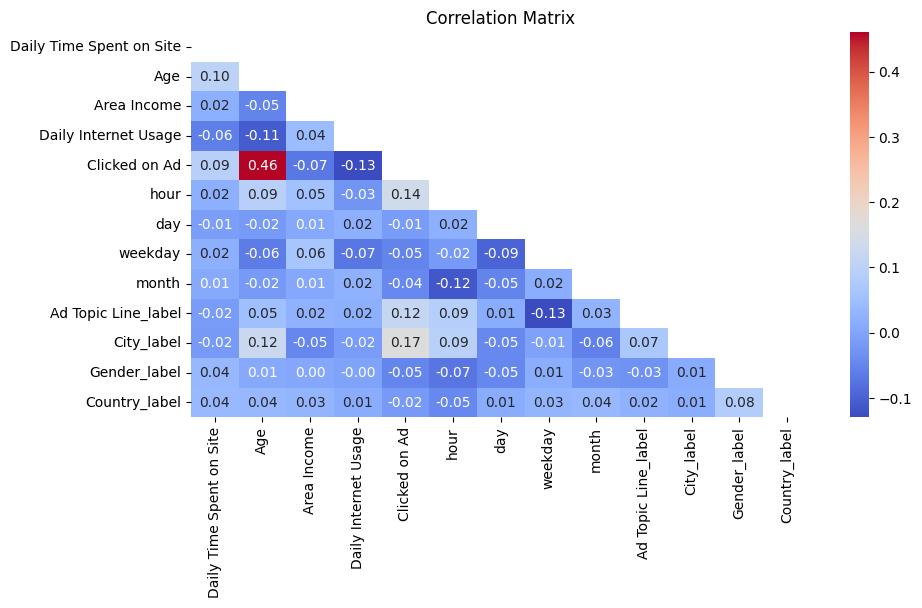

In [9]:
# multicollinearity check
correlation_matrix = df[df.select_dtypes(include = 'number').columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (10, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', mask = mask)
plt.title('Correlation Matrix')
plt.show()

# will be useful while I'm assess the reliability of my non tree-based models PartialDependence plots

**Observation**   

`Age` is the only variable with a questionable correlation with clicking on add... I will investigate further, and if my trained models seem to be overfitting on training and/or test data, age will be the first column to be dropped during the next round of feature selection.

#### [Age & Income Impact](#Q:-How-does-user-demographic-information-(age,-income)-relate-to-CTR?)

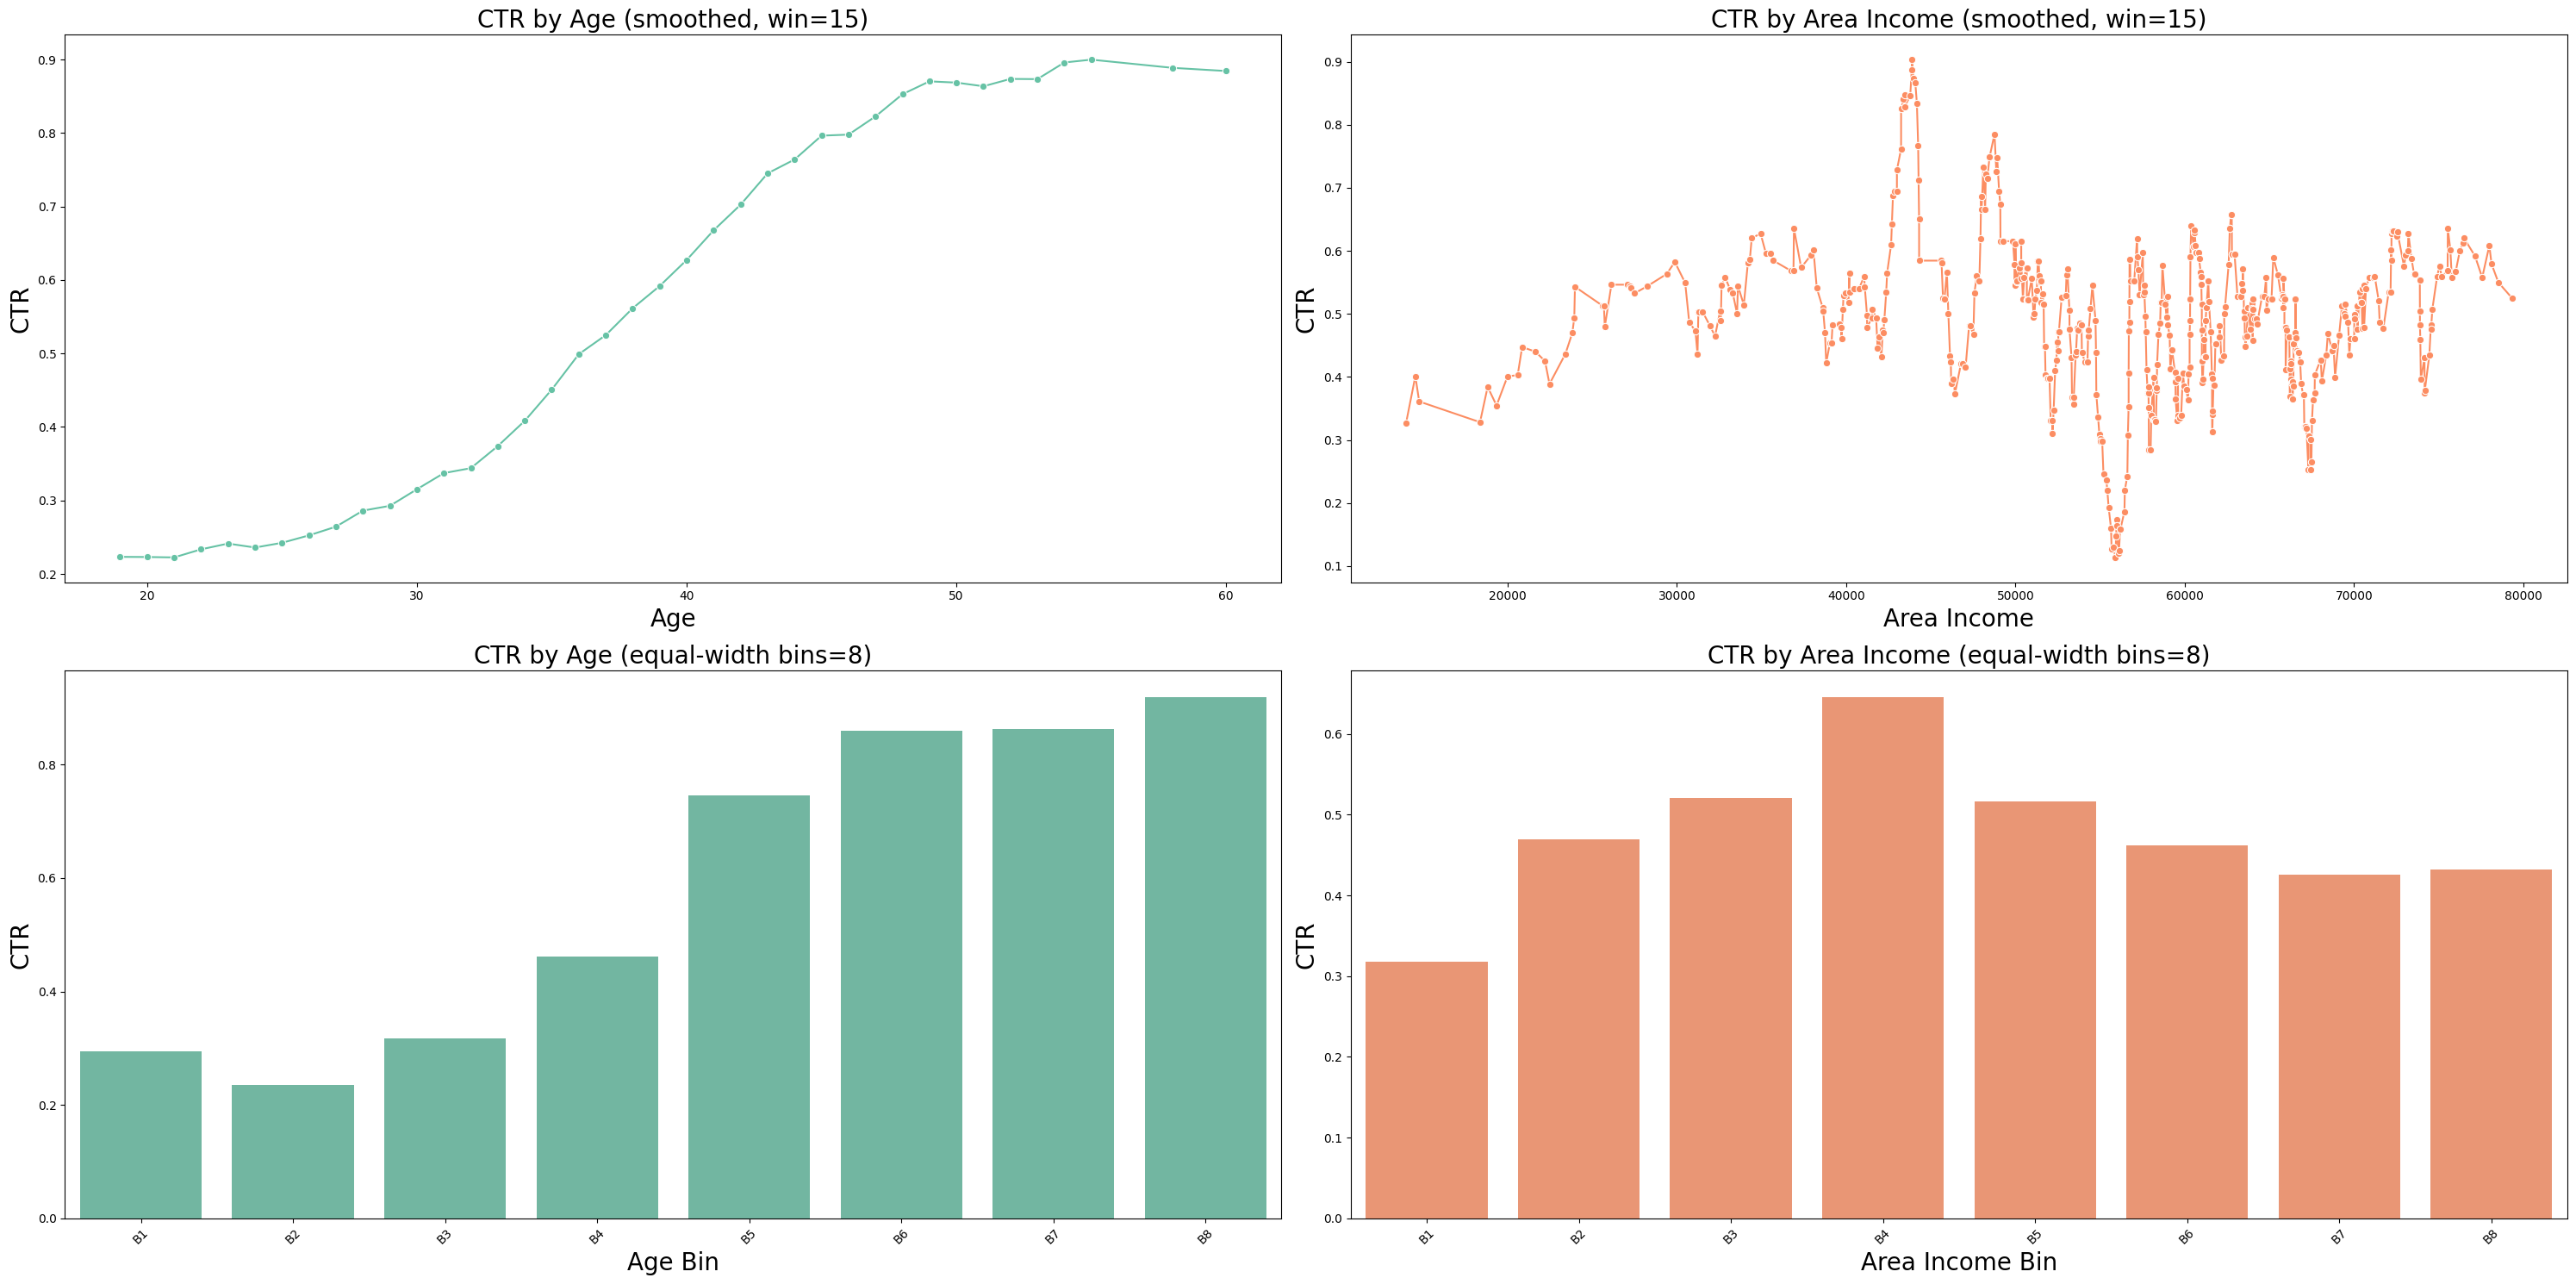

In [10]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['Age', 'Area Income'],
    n_rows = 2,
    n_cols = 2,
    n_bins = 8,
    figsize = (30, 15),
    rolling_window = 15,
    num_colors = sns.color_palette("Set2", 8))

**Observation**   

CTR increases significantly with **age**, rising from low levels in younger users to a peak among those in their **50s and 60s**.  
In contrast, the relationship with **area income** is non-linear, with CTR peaking at **middle-income levels** (~40K) and declining at higher incomes.


> Might be interesting to see the relationship between age and area income.... For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

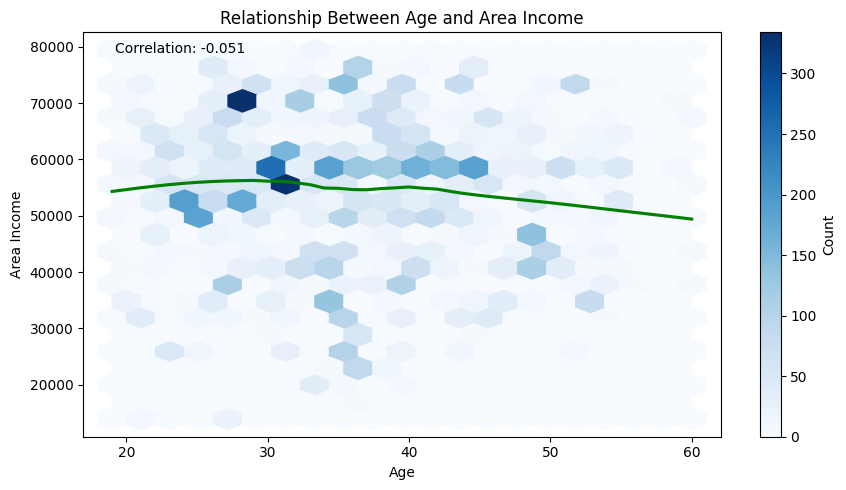

In [11]:
plt.figure(figsize = (9, 5))

plt.hexbin(df['Age'], df['Area Income'], gridsize = 20, cmap = 'Blues')
plt.colorbar(label = 'Count')

sns.regplot(data = df, x = 'Age', y = 'Area Income', scatter = False, 
            lowess = True, line_kws = {'color': 'green'})

plt.title('Relationship Between Age and Area Income')
plt.xlabel('Age')
plt.ylabel('Area Income')

correlation = df['Age'].corr(df['Area Income'])
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy = (0.05, 0.95), xycoords = 'axes fraction')

plt.tight_layout()
plt.show()

**Observation**   

Well.... The relationship is `definitely not linear`. Age and individual income might have shown a different trend.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

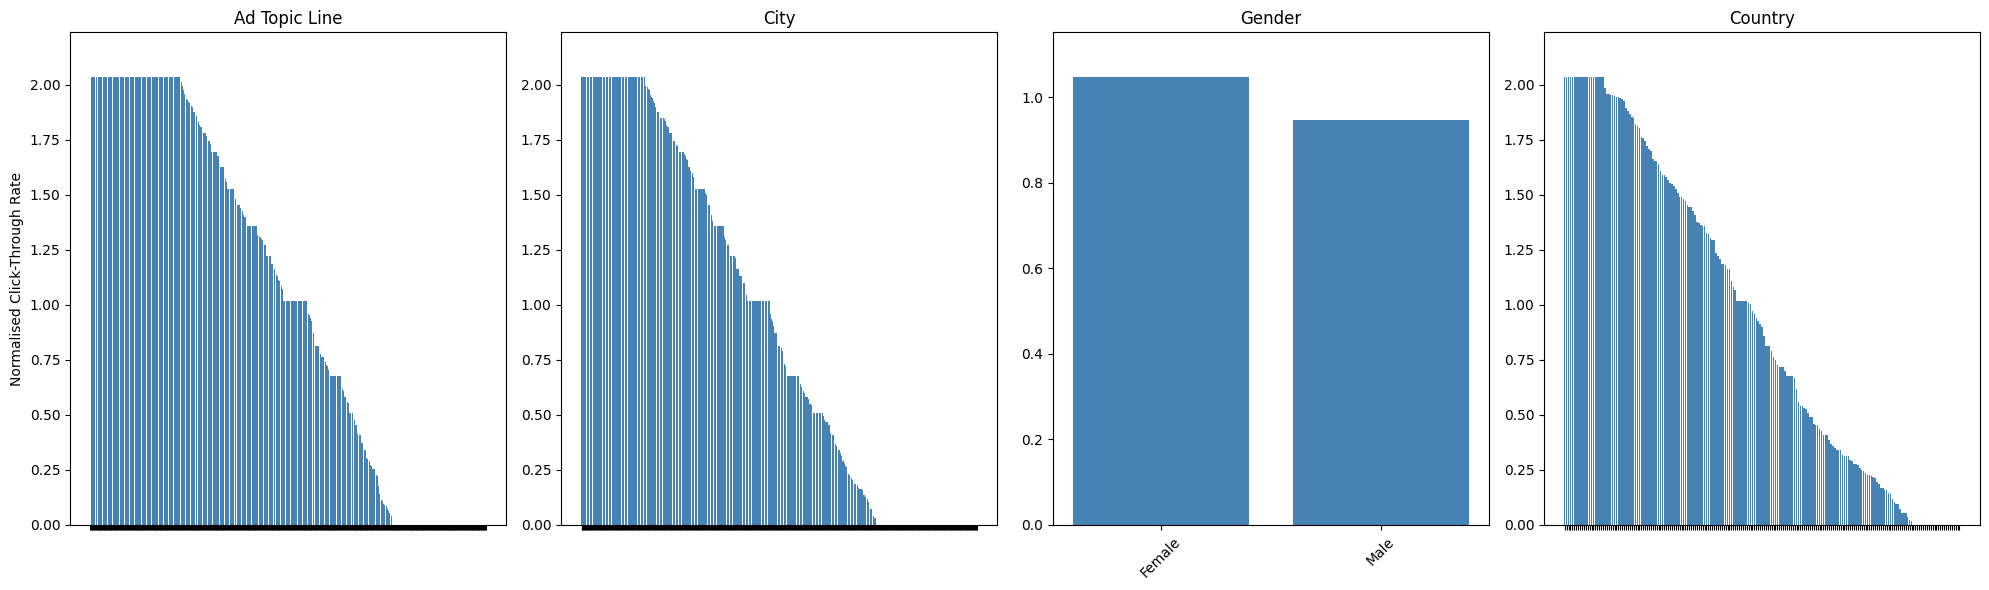

In [12]:
categorical_cols = df.select_dtypes(include ='object').columns.tolist()

# Calculate overall CTR for the entire dataset
total_clicks = df['Clicked on Ad'].sum()
total_impressions = len(df)
overall_ctr = total_clicks / total_impressions

plt.figure(figsize = (20, 6))

for i, col in enumerate(categorical_cols, start=1):
    # Calculate total clicks and ads sent by category
    clicks_by_col = df.groupby(col)['Clicked on Ad'].sum()
    ads_sent_by_col = df.groupby(col)['Clicked on Ad'].count()
    
    # CTR for each category
    ctr_by_col = clicks_by_col / ads_sent_by_col    
    normalised_ctr_by_col = ctr_by_col / overall_ctr
    normalised_ctr_by_col = normalised_ctr_by_col.sort_values(ascending = False)
    
    plt.subplot(1, len(categorical_cols), i)
    bars = plt.bar(range(len(normalised_ctr_by_col)), normalised_ctr_by_col.values, color = 'steelblue')
    
    plt.title(f'{col}', fontsize = 12)
    plt.ylim(0, normalised_ctr_by_col.max() * 1.1)
    
    if col == 'Gender':
        plt.xticks(range(len(normalised_ctr_by_col)), normalised_ctr_by_col.index, rotation=45)
    else:
        plt.xticks(range(len(normalised_ctr_by_col)), [' '] * len(normalised_ctr_by_col))
    
    if i == 1:
        plt.ylabel('Normalised Click-Through Rate')

plt.tight_layout()
plt.show()

**Observation**   

From the plots above, it looks like certain `ad topic lines, cities`, and `coutries` are associated with higher click-through-rates, and as for Gender, `Females` account for a majority of the click-through-rates. All plots above have been normalised to avoid the ***base rate fallacy.***

**Let's find out the top/bottom 10 performing Topic lines, Cities, and Countries.**

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

#### [Topic & Location Impact](#Q:-Do-certain-types-of-'Ad-Topic-Line'-perform-better-in-terms-of-CTR?)


Top cities in the top countries:


,City,Country



Bottom cities in the bottom countries:


,City,Country


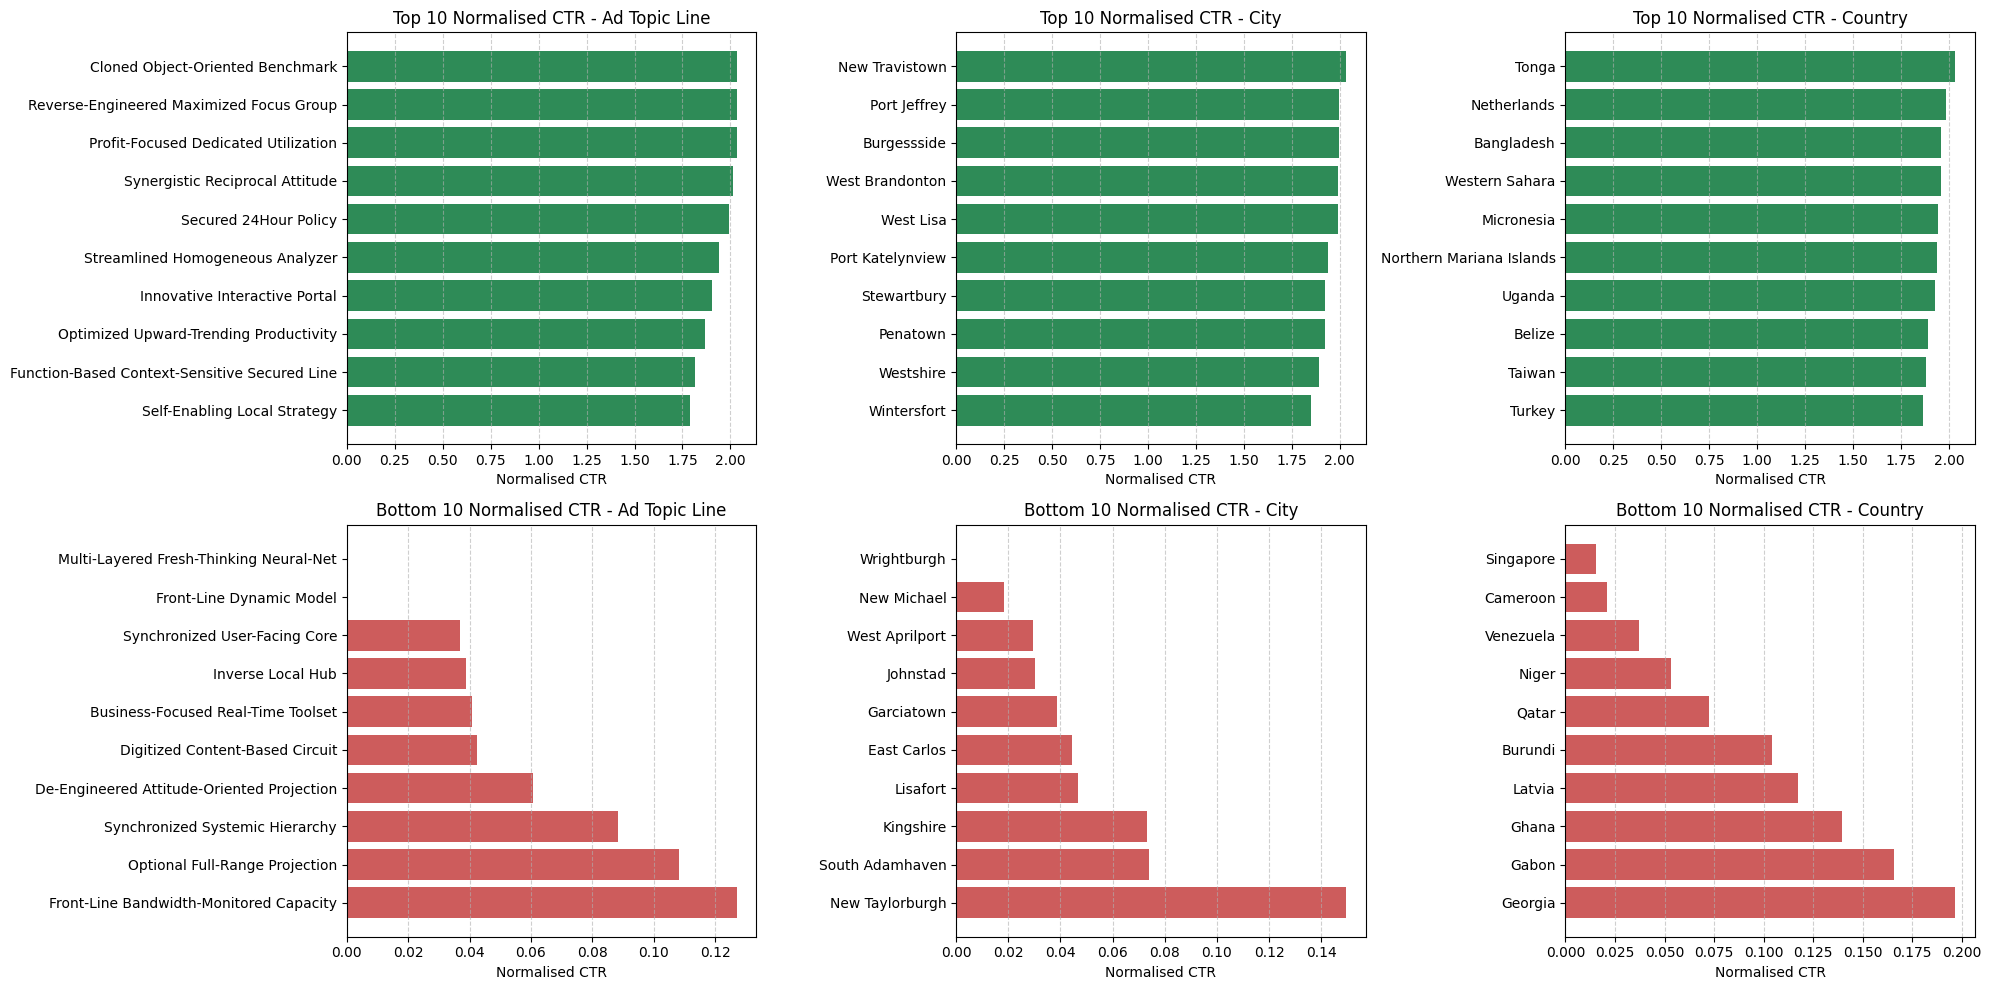

In [13]:
min_volume = 50
categorical_cols = ['Ad Topic Line', 'City', 'Country']

# overall CTR for the entire dataset
plt.figure(figsize = (20, 10))
for i, col in enumerate(categorical_cols):
    # Group by category and calculate CTR
    grouped = df.groupby(col)['Clicked on Ad']
    clicks = grouped.sum()
    impressions = grouped.count()
    ctr = clicks / impressions

    # normalise CTR by overall CTR
    normalised_ctr = ctr / overall_ctr  

    # filtering out low-volume categories
    valid = impressions[impressions >= min_volume].index
    normalised_ctr = normalised_ctr.loc[valid]
    impressions = impressions.loc[valid]

    # Top 10 and bottom 10
    top_10 = normalised_ctr.sort_values(ascending = False).head(10)
    bottom_10 = normalised_ctr.sort_values().head(10)

    plt.subplot(2, len(categorical_cols), i + 1)
    plt.barh(top_10.index[::-1], top_10.values[::-1], color = 'seagreen')
    plt.title(f'Top 10 Normalised CTR - {col}')
    plt.xlabel('Normalised CTR')
    plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)

    plt.subplot(2, len(categorical_cols), i + 1 + len(categorical_cols))
    plt.barh(bottom_10.index[::-1], bottom_10.values[::-1], color = 'indianred')
    plt.title(f'Bottom 10 Normalised CTR - {col}')
    plt.xlabel('Normalised CTR')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # top/bottom cities in relation to their country
    if col == 'City':
        top_cities = top_10.index
        bottom_cities = bottom_10.index

        # Corresponding countries for top and bottom cities
        top_cities_countries = df[df['City'].isin(top_cities)][['City', 'Country']].drop_duplicates()
        bottom_cities_countries = df[df['City'].isin(bottom_cities)][['City', 'Country']].drop_duplicates()

        # Top countries from the 'Country' column
        top_countries = normalised_ctr.sort_values(ascending = False).head(10).index
        bottom_countries = normalised_ctr.sort_values().head(10).index

        # Are top cities from the top countries?
        top_cities_from_top_countries = top_cities_countries[top_cities_countries['Country'].isin(top_countries)]
        bottom_cities_from_bottom_countries = bottom_cities_countries[bottom_cities_countries['Country'].isin(bottom_countries)]

        print(f"\nTop cities in the top countries:")
        display(top_cities_from_top_countries)
        print(f"\nBottom cities in the bottom countries:")
        display(bottom_cities_from_bottom_countries)

plt.tight_layout()
plt.show()

**Observation**   

Surprisingly enough, none of the top cities are from the top countries, and none of the bottom cities are from the bottom countries.

> Disclaimer :) This unfortunately is toy data... In reality, I expect that at least 1 of the top/lowest cities might fall within the top/bottom countries respectively. For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

#### [Time-Based-Impact](#Q:-Do-time-based-behavior-(e.g.,-daily-time-spent-on-site,-internet-usage,-timestamp-patterns)-influence-likelihood-of-clicking-on-ads?)

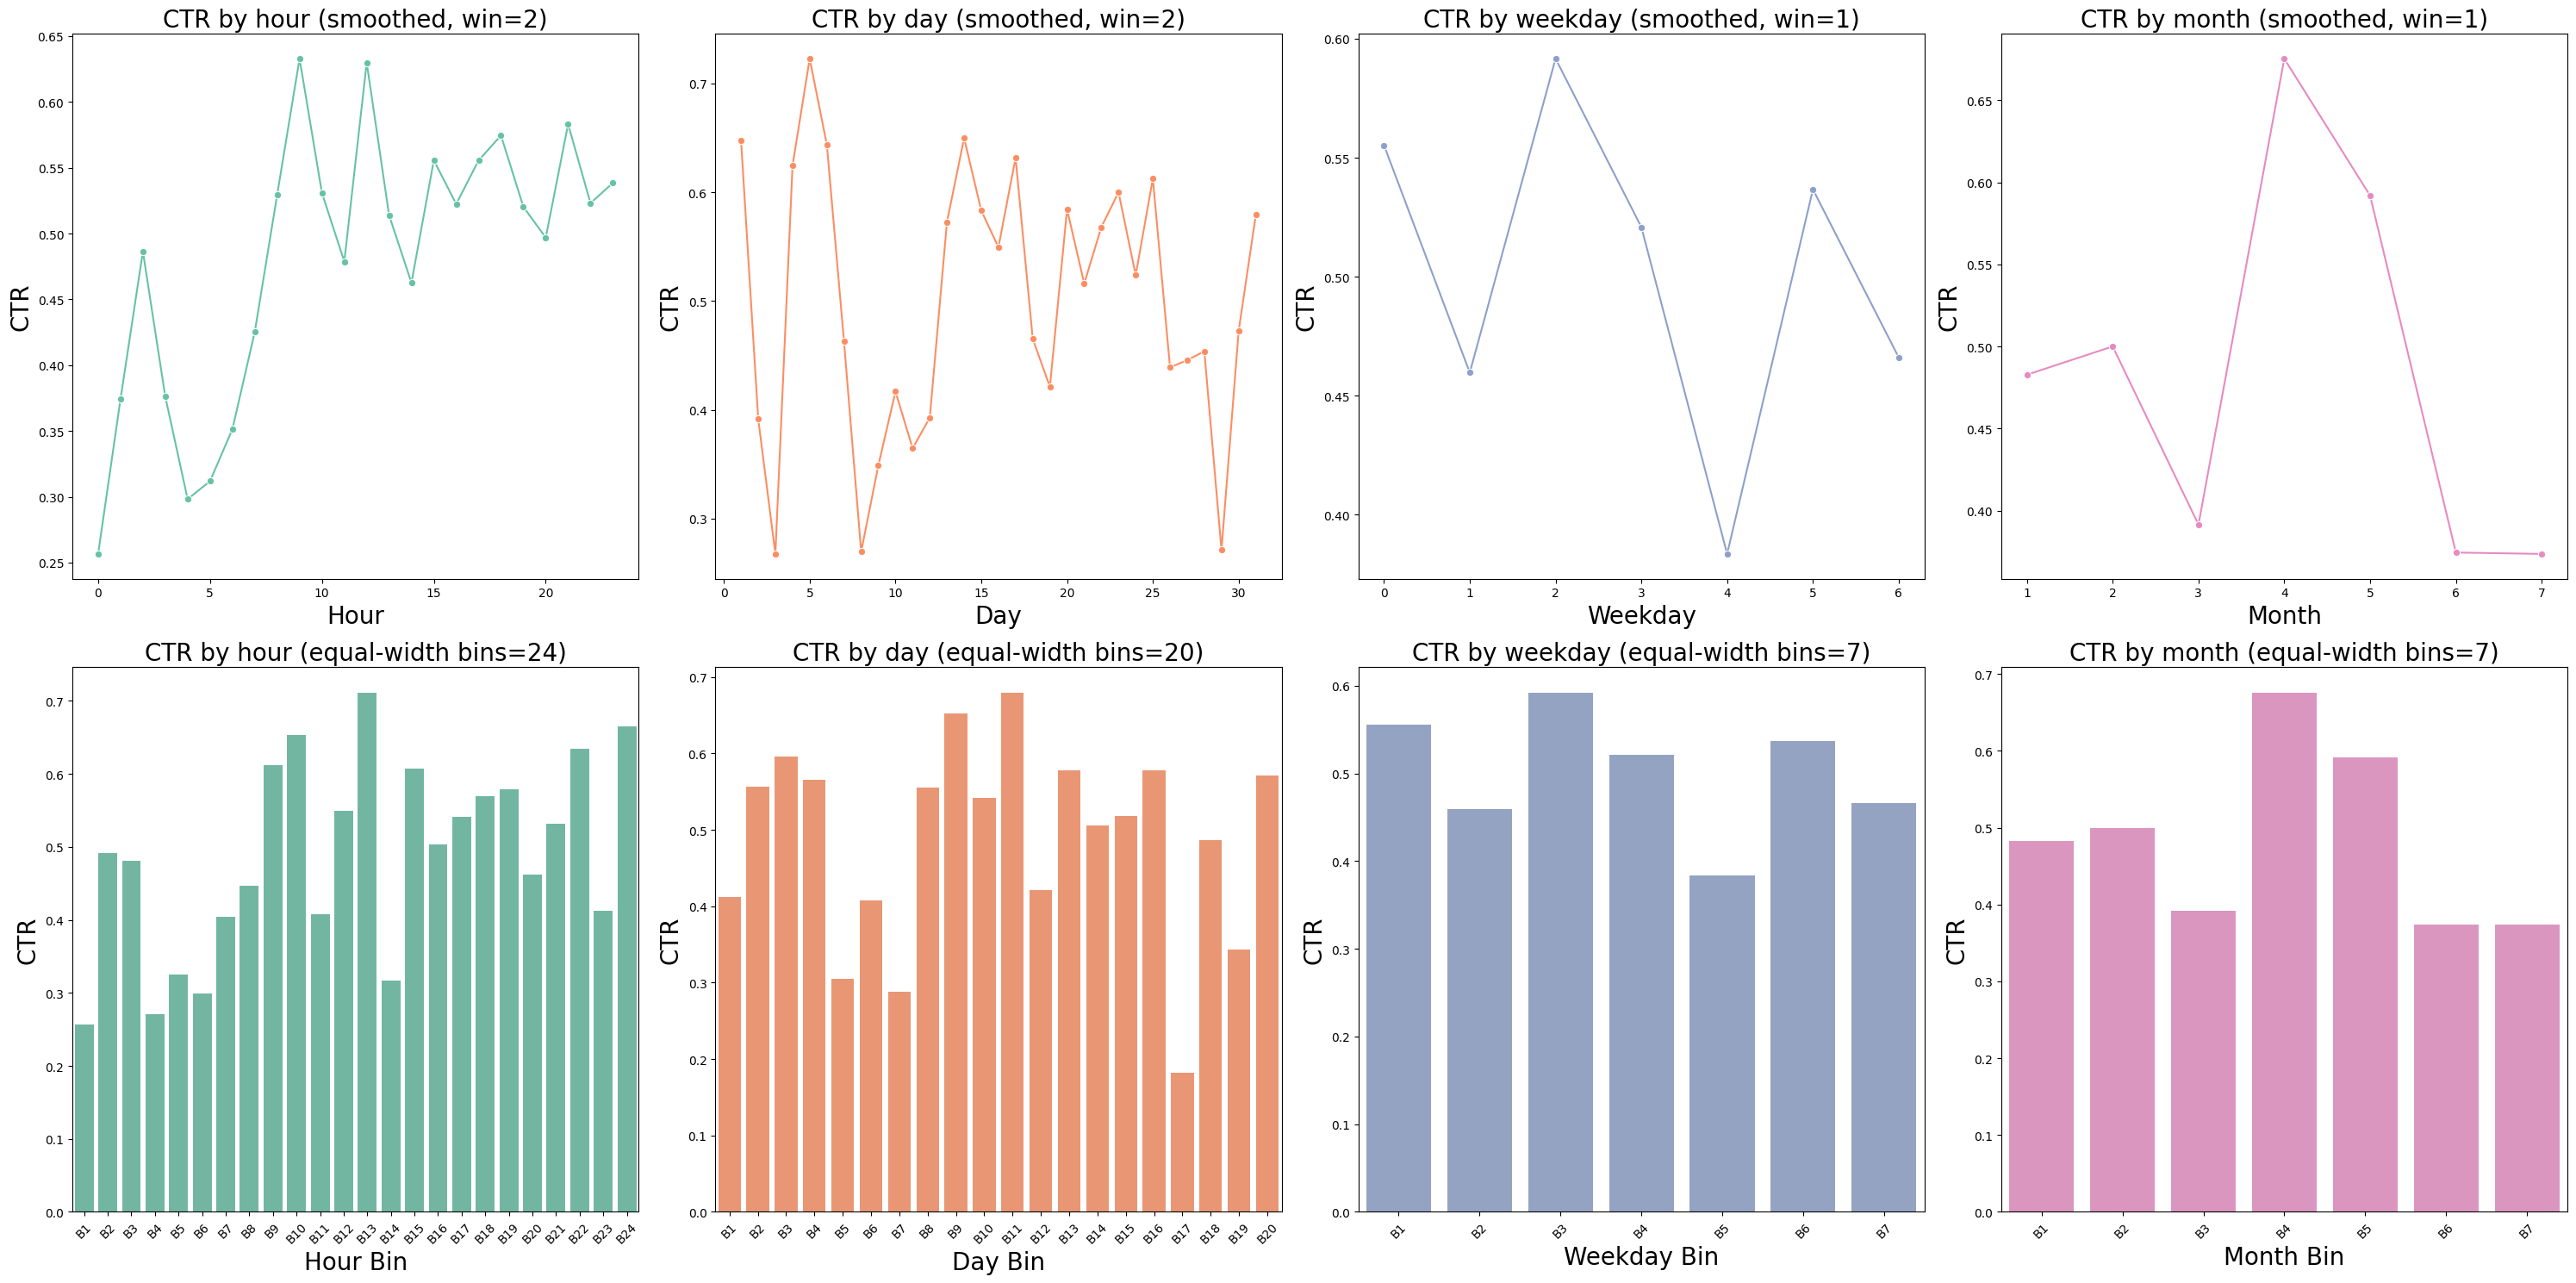

In [14]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['hour', 'day', 'weekday', 'month'],
    n_rows = 2,
    n_cols = 4,
    n_bins = 7,
    bins_map = {'hour': 24,'day': 20, 'month': 7},
    smooth_map = {'hour': 2,'day': 2},
    figsize = (30, 15),
    rolling_window = 1,
    num_colors = sns.color_palette("Set2", 8))

In [15]:
sorted(df.month.unique())
# Since I specified 7 bins for month above, the bin B4 in the months plot
# corresponds to the 4th month in the list below... where 1 is January.

[1, 2, 3, 4, 5, 6, 7]

**Observation**   

Ad performance varies significantly across time. Click-through rates (CTR) peak during specific **hours (10AM, 12PM, and 8PM)** and **days (Wednesdays, as well as start and middle of the month)**, while ad delivery tends to concentrate **late at night**. Notably, **April (B4) sees the highest monthly CTR**, followed by a noticeable dip in **June and July**.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

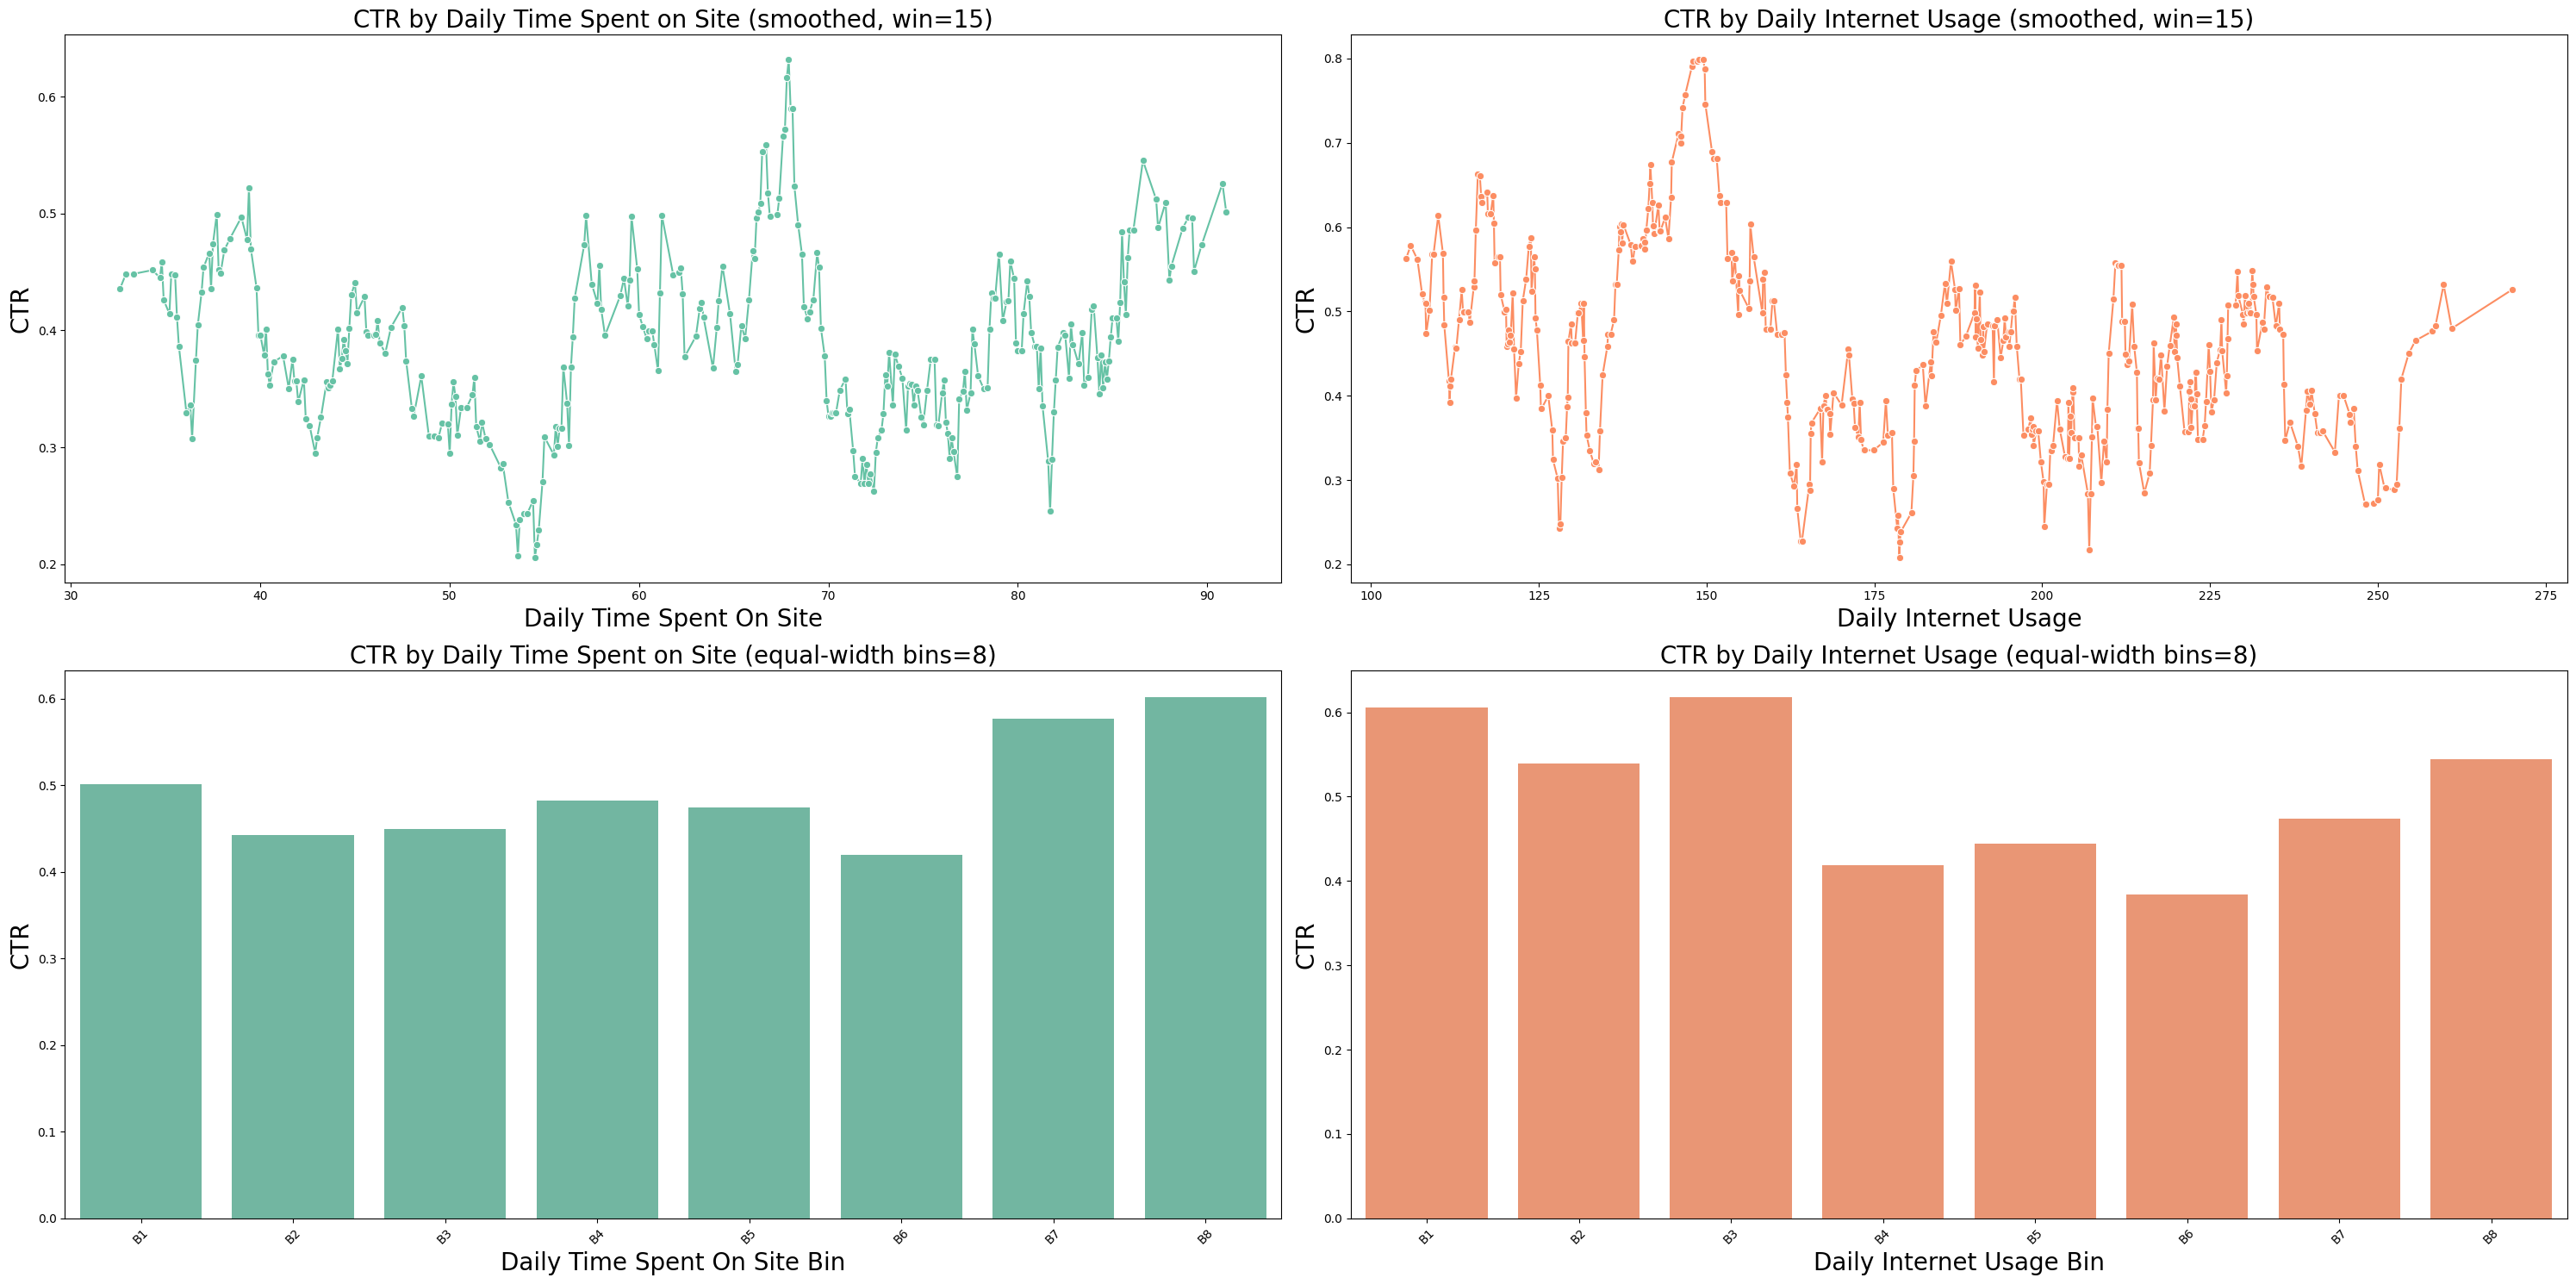

In [16]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['Daily Time Spent on Site', 'Daily Internet Usage'],
    n_rows = 2,
    n_cols = 2,
    n_bins = 8,
    figsize = (30, 15),
    rolling_window = 15,
    num_colors = sns.color_palette("Set2", 8))

**Observation**   

CTR tends to increase with moderate user engagement, peaking with **around 70 minutes on site** and **moderate daily internet usage** but declines at extreme levels.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

#### Relationship Between Internet Use & Time on Site

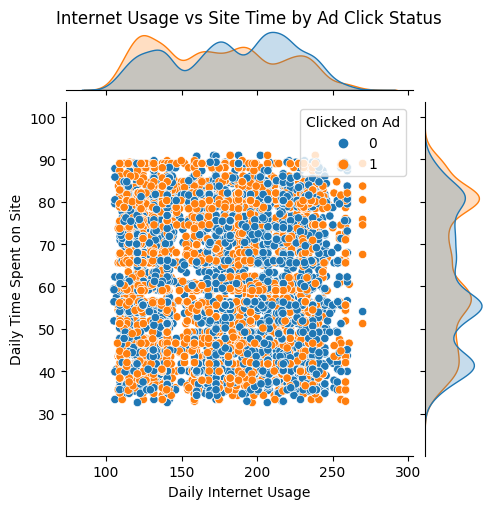

In [17]:
sns.jointplot(
    data = df,
    x = 'Daily Internet Usage',
    y = 'Daily Time Spent on Site',
    hue = 'Clicked on Ad',
    height = 5)

plt.suptitle('Internet Usage vs Site Time by Ad Click Status', y = 1.01) #, x = 0.008)
plt.show()

**Observation**   
There is no observable effect on the interaction between daily time spent on site and daily internet usage, and their impact on clicking... The values are mixed with each other, with no clear separation.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

<!-- BACKUP.... -->
<!-- ---

### Key Findings

#### (EDA-Based)

- #### [***Q***: *How does user demographic information (age, income) relate to CTR?*](#Age-&-Income-Impact)
  **A**: *...*

- #### [***Q***: *Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?*](#Time-Based-Impact)  
  **A**: `Yes`, ad-clicks vary by several time-based behavioral factors:  
  - **Daily Time Spent on Site**: CTR increases with longer time spent, peaking around 70 minutes, with a dip around the 55-minute mark.  
  - **Daily Internet Usage**: CTR is highest at moderate usage levels around 140–150, and declines with higher usage.  
  - **Hourly Performance**: CTR peaks around 10 AM, with another strong window in the evening (20–22); ad volume is highest late at night (21–23).  
  - **Daily Patterns**: CTR shows high day-to-day volatility, with particularly strong performance at the start of the month.  
  - **Weekday Performance**: Wednesday shows the highest CTR, while Sunday has the lowest; ad delivery is highest on Thursday and Sunday.  
  - **Monthly Trends**: CTR peaks in April, coinciding with the highest ad volume, then it drops `significantly` in June and July.

- #### [***Q***: *Are there geographic differences in ad engagement (by city or country)?*](#Topic-&-Location-Impact)
  **A**: **`Yes`**. Cities such as `New Travistown` and `Westshire`, along with countries like `Tonga` and `Netherlands`, account for the highest CTRs. In contrast, cities like `Gracitown` and `Kingshire`, and countries such as `Singapore` and `Cameroon`, show the lowest recorded CTRs. 

- #### [***Q***: *Do certain types of 'Ad Topic Line' perform better in terms of CTR?*](#Topic-&-Location-Impact)  
  **A**: **`Yes`**. Ad Topic lines such as `Cloned Object-Oriented Benchmark`, `Innovative Interactive Portal`, etc., are amongst the top performers, while `Front-Line Dynamic Model` and `Inverse Local Hub` are associated with the lowest clicks.

- #### [***Q***: *What is the relationship between internet use and time on site, and how do those correlate with CTR?*](#Topic-&-Location-Impact)  
  **A**: *...*

#### (Post Model-Training)

- *...*

---
 -->

---

### Key Findings

#### (EDA-Based)

- #### [***Q***: *How does user demographic information (age, income) relate to CTR?*](#Age-&-Income-Impact)
  **A**: User demographic features have varying impact on CTR with the following specifications

  - **Age**: CTR increases steadily with age. From as low as ~0.2 from users' in their 20s, rising further between 30s and 40s, and peaking around 0.9 for users in their 50s - 60s.
  - **Income** CTR shows a non-linear relationship with area income, peaking among middle-income areas around $40K, and then gradually declining beyond that point.


- #### [***Q***: *Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?*](#Time-Based-Impact)  
  **A**: `Yes`, ad-clicks vary by several time-based behavioral factors:  
  - **Daily Time Spent on Site**: CTR increases with longer time spent, peaking around 70 minutes, with a dip around the 55-minute mark, and after its peak.
  - **Daily Internet Usage**: CTR is highest at moderate usage levels around 140–150, and declines with higher usage.  
  - **Hourly Performance**: CTR steadily increases through the morning and peaks twice `around 10AM, and 12PM`. There's another rise after 8PM.  
  - **Daily Patterns**: CTR is `highly volatile across days`. `Strong performance` is observed at the `start of the month` and again around the `23rd–26th`.   
  - **Weekday Performance**: `Wednesday` stands out with the `highest CTR`, possibly reflecting mid-week browsing intent. `Friday` has the `lowest CTR`, indicating users might be less engaged heading into the weekend.
  - **Monthly Trends**: CTR peaks in April, coinciding with the highest ad volume, then it drops `significantly` in June and July... Some sort of seasonal trend.

- #### [***Q***: *Are there geographic differences in ad engagement (by city or country)?*](#Topic-&-Location-Impact)
  **A**: **`Yes`**. Cities such as `New Travistown` and `Westshire`, along with countries like `Tonga` and `Netherlands`, account for the highest CTRs. In contrast, cities like `Gracitown` and `Kingshire`, and countries such as `Singapore` and `Cameroon`, show the lowest recorded CTRs. 

- #### [***Q***: *Do certain types of 'Ad Topic Line' perform better in terms of CTR?*](#Topic-&-Location-Impact)  
  **A**: **`Yes`**. Ad Topic lines such as `Cloned Object-Oriented Benchmark`, `Innovative Interactive Portal`, etc., are amongst the top performers, while `Front-Line Dynamic Model` and `Inverse Local Hub` are associated with the lowest clicks.

- #### [***Q***: *What is the relationship between internet use and time on site, and how do those correlate with CTR?*](#Relationship-Between-Internet-Use-&-Time-on-Site)  
  **A**: Even though they individually have their impact, the relationship between internet usage and time spent on site doesn't show a strong pattern of correlation with ad click behavior.

#### (Post Model-Training)

- *...*

---
